# **NLG Hallucination Detection**

Hallucinations are when a model confidently presents an incorrect or unfactual response to an end user. They are the most popular critizism and risk assosiated with LLMs and natural language generation. Mitigating Halluncinations is critical for user safety and application adoption.

There are two types of halluncinations...
1. Open-domain: Flase claims that contradict a ground truth
2. Closed-domain: Deviations from the context of a specific reference text (i.e. RAG)  
  
...and there are two categories of hallucination prevention:
1. Mitigation: Prevention methods before a response is generated using techniques like Prompt Engineering ("Say I don't know") or RAG
2. Detection: Analyzing the response after it is generated. These can be used in-line to prevent a hallucenated response from being presented to a user

Most state-of-the-art detection methods to date involve sampling multiple responses from you chat and analyzing the entire response set to identify hallucination risk. [How to Perform Hallucination Detection by Mark Chen](https://towardsdatascience.com/how-to-perform-hallucination-detection-for-llms-b8cb8b72e697) provides a great overview of the latest and most effective methods.

**This notebook** will use Azure PromptFlow to implement 4 techniques of **_halluncination  detection_** inline with chat or Q&A response:
1. **Hughes Hallucination Evaluation Model**: Open source Hugues Hallucination Evaluation model (fine-tuned deberta-v3-base) model for hallucination detection. 
2. **Natural Language Inference (NLI) Contradiction Score**: Use the SelfCheckGPT framework + nli-deberta-v3-base OOS language model to evaluate sample contradiction
3. **Self-Consistency Chain-of-Thought (CoT)**: Use GPT-4 to evaluate consistency between samples and responses
4. **ChainPoll**: Make multiple calls to GPT4 to poll for halluncination likelihood
  
The notebook will use a subsample of the [wiki_bio_gpt3_hallucination](https://huggingface.co/datasets/potsawee/wiki_bio_gpt3_hallucination) human labeled dataset, available on hugging face to assess detection results. 

**_Go Deeper_**  
    
- HHEM: [Hughes Hallucination Evaluation Model (HHEM)](https://huggingface.co/vectara/hallucination_evaluation_model)  
- Contradiction Scoring: [Self-contradtctory Hallucinations of Large Language Models](https://arxiv.org/pdf/2305.15852v1.pdf) & [With a Little Push, NLLI Models can Robustly and Efficiently Predict Faithfulness](https://arxiv.org/pdf/2305.16819.pdf)  
- Consistency Scoring: [Semantic Consistency for Assuring Reliability of LLMs](https://arxiv.org/pdf/2308.09138.pdf)
- ChainPoll: [ChainPoll: A High Efficacy Method for LLM Hallucination Detection](https://arxiv.org/pdf/2310.18344v1.pdf)  
- Self-Check GPT: Zero-Resource Black-Box Hallucination Detection for Generative LLMs ([Paper](https://arxiv.org/pdf/2303.08896.pdf)/[Code](https://github.com/potsawee/selfcheckgpt))  
  
**_Prerequisites_**  
  
- Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)

In [1]:
# Get a handle to the AML workspace

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from datasets import load_dataset, Value
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv(), override=True)
print(os.getenv("WORKSPACE_NAME"))

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

nlg-eval-aml


In [2]:
# Load dataset
wiki_bio = load_dataset("potsawee/wiki_bio_gpt3_hallucination")['evaluation']

# Get subsample
wiki_bio_sample = wiki_bio.filter(lambda wiki_bio, idx: idx % 7 == 0, with_indices=True)

# Convert to pandas
wiki_bio_sample_df = wiki_bio_sample.to_pandas()

# Add baseline label column
wiki_bio_sample_df["label"] = 0

display(wiki_bio_sample_df.dtypes)

gpt3_text            object
wiki_bio_text        object
gpt3_sentences       object
annotation           object
wiki_bio_test_idx     int64
gpt3_text_samples    object
label                 int64
dtype: object

In [3]:
# Process Data
level = "major_inaccurate" # change to "minor_inaccurate" if you want to include minor inaccuracies


def trim_samples(samples):
    # Trim gpt3_text_samples from 20 to 5
    return samples[:5]

def code_annotations(annotations):
    # Convert to singular binary hallucination classifier
    # If annotation contains (major_inaccurate/minor_inaccurate) then label as 1
    for note in annotations:
        if note == level:
            return 1
    return 0

wiki_bio_sample_df["gpt3_text_samples"] = wiki_bio_sample_df["gpt3_text_samples"].apply(lambda x : trim_samples(x))
wiki_bio_sample_df["gpt3_text_sample_size"] = wiki_bio_sample_df["gpt3_text_samples"].apply(lambda x : len(x)) # validation trim_samples works
wiki_bio_sample_df['label'] = wiki_bio_sample_df['annotation'].apply(lambda x: code_annotations(x))

# Drop index and original annotation
wiki_bio_sample_df = wiki_bio_sample_df.drop(columns=['annotation', 'wiki_bio_test_idx'])

# Write to output folder as jsonl #TODO
wiki_bio_sample_df.to_json("../data/inputs/wiki_bio_gpt3_hallucination.jsonl", orient="records", lines=True)

display(wiki_bio_sample_df.head(5))

,gpt3_text,wiki_bio_text,gpt3_sentences,gpt3_text_samples,label,gpt3_text_sample_size
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",[John Russell Reynolds (1820–1876) was an Engl...,[John Russell Reynolds (1 November 1829 – 11 ...,1,5
1,Wilhelm Windelband (15 March 1848 – 18 Septemb...,"Wilhelm Windelband (May 11, 1848 - October 22,...",[Wilhelm Windelband (15 March 1848 – 18 Septem...,[Wilhelm Windelband (15 March 1848 – 15 Novemb...,1,5
2,"Dawn Landes (born August 8, 1979) is an Americ...","Dawn Landes (born December 5, 1980) is an Amer...","[Dawn Landes (born August 8, 1979) is an Ameri...","[""Dawn Landes is an American singer-songwriter...",1,5
3,Frank A. McLain (1890–1962) was an American la...,"Frank Alexander McLain (January 29, 1852 - Oct...",[Frank A. McLain (1890–1962) was an American l...,"[Frank A. McLain (April 14, 1884 – April 1, 19...",1,5
4,Gordon David Strachan (born 9 February 1957) i...,Gordon David Strachan OBE (born 9 February 195...,[Gordon David Strachan (born 9 February 1957) ...,[Gordon David Strachan (born 9 February 1957) ...,0,5


## 2. Run Hallucination Detection w/ Azure PromptFlow
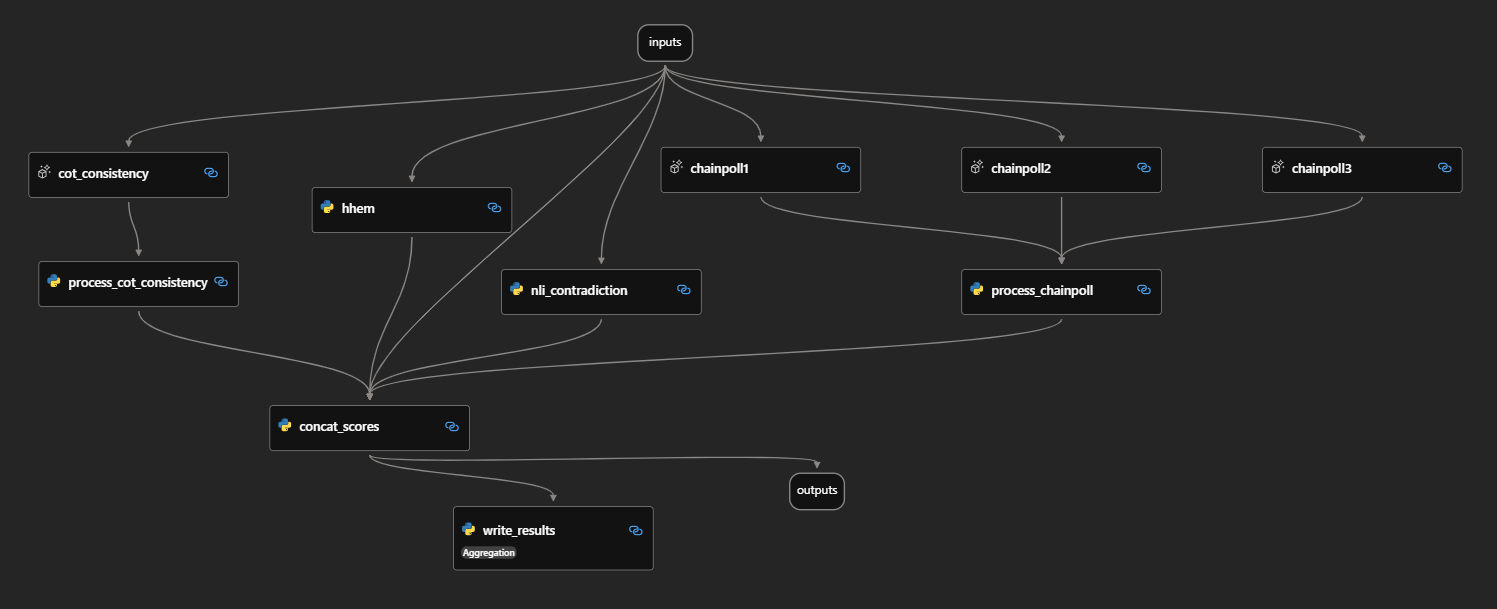

In [4]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
halu_detect = "../src/promptflow/evaluation_flows/hallucination_detection" # set the flow directory
data =  "../data/inputs/wiki_bio_gpt3_hallucination.jsonl" # set the data file

# Run chat flow to generate chat results
halu_detect_run = pf.run(
    flow=halu_detect,
    data=data,
    stream=False,
    environemnt_variables = {"TOKENIZERS_PARALLELISM": "false"},
    column_mapping={  # map the url field from the data to the url input of the flow
      "response": "${data.gpt3_text}",
      "context": "${data.wiki_bio_text}",
      "samples": "${data.gpt3_text_samples}",
      "response_sentences": "${data.gpt3_sentences}",
      "human_label": "${data.label}"
    }
) 

# pf.stream(halu_detect_run)
# pf.get_metrics(halu_detect_run)

[2024-02-08 08:00:14,851][promptflow._sdk._submitter.run_submitter][INFO] - Submitting run hallucination_detection_variant_0_20240208_080014_597801, log path: /home/zacksoenen/.promptflow/.runs/hallucination_detection_variant_0_20240208_080014_597801/logs.txt.


: 

## 3. Analyze Results

## 4. Analyze Performance and Latency